In [67]:
import pandas as pd # for data analytics
import numpy as np # for numerical computation
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools
from tqdm import tqdm

In [215]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
dataset = pd.read_csv("/Users/s0c02nj/Desktop/Class Imbalance/creditcard.csv")

dataset['Amount'] = np.log(dataset['Amount'] + 1)
dataset['Time'] = np.log(dataset['Time'] + 1)
normal = dataset[dataset['Class'] == 0]

anomaly = dataset[dataset['Class'] == 1]
print(normal.shape)
print(anomaly.shape)

(284315, 31)
(492, 31)


To split the data, we will hold 50% of the normal instances for training. The rest of the normal data will be equally split among a validation and a test set. The abnormal instances will also be equally spitted between the validation and test set.

In [4]:
from sklearn.model_selection import train_test_split

#Two different version of the data with labels 0
train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

#Two different version of normal_test
normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)

#Anomaly two versions
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test =  normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (227452, 31)
Proportion os anomaly in training set: 0.00

Valid shape:  (28677, 31)
Proportion os anomaly in validation set: 0.01

Test shape:,  (28678, 31)
Proportion os anomaly in test set: 0.01



Gaussian Dist

In [18]:
#Defining the Multivariate Normal
from scipy.stats import multivariate_normal

mu =    train.drop('Class', axis=1).mean(axis=0).values
sigma = train.drop('Class', axis=1).cov().values
model = multivariate_normal(cov=sigma, mean=mu, allow_singular=True)

In [44]:
#Mean/Median of the distribution of zeros
print(np.median(model.logpdf(test[test['Class'] == 0].drop('Class', axis=1).values))) 

#Mean/Median of the distribution of zeros
print(np.median(model.logpdf(test[test['Class'] == 1].drop('Class', axis=1).values))) 


-32.75698993277335
-722.2463231835197


Determining the threshold for Log-Probabilities

In [68]:
thresholds = np.linspace(-1000,-30, 150)
scores = []
for threshold in tqdm(thresholds):
    y_hat = (model.logpdf(valid.drop('Class', axis=1).values) < threshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

100%|██████████| 150/150 [00:03<00:00, 40.85it/s]

0.749395648670427 112


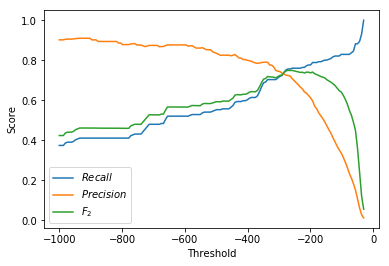

In [209]:
plt.plot(thresholds, scores[:, 0], label='$Recall$')
plt.plot(thresholds, scores[:, 1], label='$Precision$')
plt.plot(thresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
# plt.xticks(np.logspace(-10, -200, 3))
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [211]:
final_tresh = thresholds[scores[:, 2].argmax()]
final_tresh

-270.8724832214765

Final threshold: -270
Test Recall Score: 0.789
Test Precision Score: 0.705
Test F2 Score: 0.770


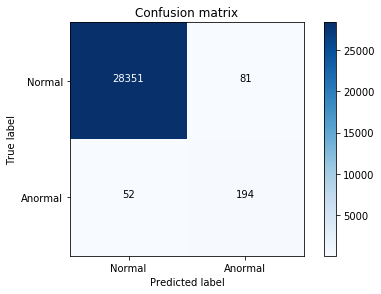

In [216]:
final_thresh = thresholds[scores[:, 2].argmax()]
y_hat_test = (model.logpdf(test.drop('Class', axis=1).values) < final_thresh).astype(int)

print('Final threshold: %d' % final_thresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal']
                     , title='Confusion matrix')

Gaussian Mixture

In [230]:
#Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=4, random_state=42)
gmm.fit(train.drop('Class', axis=1).values)

In [222]:
print(gmm.score(valid[valid['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(valid[valid['Class'] == 1].drop('Class', axis=1).values))

8.671659799583793
-67043.62823213398


In [226]:
thresholds = np.linspace(-400, 0, 100)
y_scores = gmm.score_samples(valid.drop('Class', axis=1).values)
scores = []
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.8004827031375704 74


In [229]:
final_thresh = thresholds[scores[:, 2].argmax()]
y_hat_test = (gmm.score_samples(test.drop('Class', axis=1).values) < final_thresh).astype(int)

print('Final threshold: %d' % final_thresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=2))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)

Final threshold: -101
Test Recall Score: 0.809
Test Precision Score: 0.726
Test F2 Score: 0.791


Create bins and checking if decission tree works 

+ Generating Data from two Multivariate Normal Distribution of two class
+ Merge them
+ Fit decission tree on itself to check if it works

In [192]:
x1 = np.random.normal(loc=10.0, scale=12.0, size=100)
y1 = np.zeros((len(x1)))

x2 = np.random.normal(loc=50.0, scale=12.0, size=100)
y2 = np.ones((len(x1)))

x3 = np.random.normal(loc=80.0, scale=12.0, size=100)
#y3 = np.tw((len(x1)))

x_comb = np.concatenate([x1,x2,x3])
y_comb = np.concatenate([y1,y2,y3])

In [194]:
x_comb = pd.DataFrame(x_comb)
y_comb = pd.DataFrame(y_comb)

In [182]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth=2)
dtree.fit(x_comb,y_comb)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [201]:
from sklearn.tree import DecisionTreeRegressor
dtree=DecisionTreeRegressor(max_depth=2)
dtree.fit(x_comb,x_comb)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [204]:
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus

In [205]:
#!pip install pydotplus

In [206]:
dot_data = StringIO()

In [207]:
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

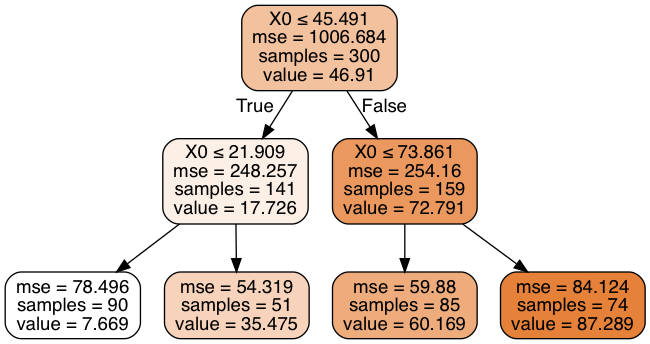

In [208]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())